# Week4　授業前課題1　アヤメの分類  
＜目的＞
- 教師あり学習（分類問題）の概観を知る
- scikit-laernを使い分類を行えるようにする
- 手法の簡単な比較をする  

Week3で使用したirisデータセットを使い、分類問題を解く練習をします。
irisデータセットはカナダのガスペ半島のある牧草地で同じ日に採取された以下の3種類のアヤメ、合計150本のデータでした。

4種類の特徴量（説明変数）からアヤメの種類を推測する問題が設定できます。アヤメの種類を **分類** するので、こういったものを分類問題と呼びます。

＜手法の一覧＞  
scikit-laernを使い以下の手法で学習と推定を行っていきます。それぞれの手法についての詳細は今の段階では扱いません。ライブラリを使えばどれも気軽に利用できることや、手法毎の結果に違いがあることを簡単に見ていきます。

- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト

まず、最近傍法を例に分類問題を解く基本的な流れを紹介します。課題の後半ではこれを参考に他の手法にも適用してもらいます。
この流れについては後々より深く学び、実践していきます。今回の課題では大まかな流れの把握を行ってください。

＜練習のための準備＞  
練習する上で結果の可視化を行いたいため、特徴量は4つの中で2つだけを使うことにします。こうすることで2次元の散布図を描き確認することができます。また、問題を単純化するためアヤメの種類を2つだけ使うことにします。分類対象が2種類の場合を 2値分類 と呼び、それ以上の 多値分類 とは区別をします。それぞれで手法や評価方法が変わります。今回はまずより基本的な2値分類を行います。

### 【課題1】練習のために特徴量とカテゴリを選択  
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

- virgicolorとvirginica
- sepal_lengthとpetal_length

**《実際の問題では？》**  
実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [87]:
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
# virgicolorとvirginica(51行目以降)を抽出
# sepal_lengthとpetal_length(1,3列目)を抽出
X = iris.data[50:, [0, 2]]
y = iris.target[50:]
X_df = pd.DataFrame(data=X)
X_df.columns = ['sepal_length', 'petal_length']
y_df = pd.DataFrame(data=y)
y_df.columns = ['Species']

display(X_df)
display(y_df)

,sepal_length,petal_length
0,7.0,4.7
1,6.4,4.5
2,6.9,4.9
3,5.5,4.0
4,6.5,4.6
...,...,...
95,6.7,5.2
96,6.3,5.0
97,6.5,5.2
98,6.2,5.4


,Species
0,1
1,1
2,1
3,1
4,1
...,...
95,2
96,2
97,2
98,2


### 【問題2】データの分析  
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。
ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

**《実際の問題では？》**  
このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。
今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

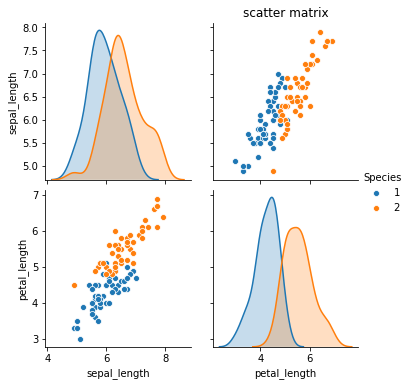

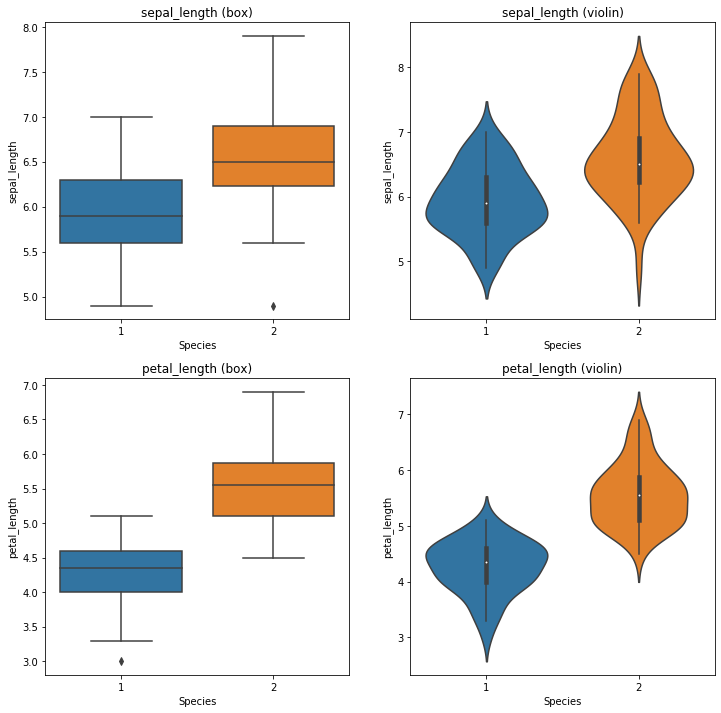

In [88]:
df = pd.concat([X_df, y_df], axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 散布図行列
sns.pairplot(df, hue='Species')
plt.title('scatter matrix')
plt.show()

# 箱ひげ図・バイオリン図
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
sns.boxplot(x="Species", y="sepal_length", data=df, ax=ax[0,0])
ax[0,0].set_title("sepal_length (box)")
sns.violinplot(x="Species", y="sepal_length", data=df, ax=ax[0,1])
ax[0,1].set_title("sepal_length (violin)")
sns.boxplot(x="Species", y="petal_length", data=df, ax=ax[1,0])
ax[1,0].set_title("petal_length (box)")
sns.violinplot(x="Species", y="petal_length", data=df, ax=ax[1,1])
ax[1,1].set_title("petal_length (violin)")
plt.show()

### 【問題3】前処理・訓練データと検証データの分割  
前処理の一貫として、訓練データと検証データの分割を行います。今回は訓練データ75%、検証データ25%として分割してください。
scikit-learnの``train_test_split``が利用できます。公式ドキュメントのExamplesを参考に動かしてください。  

**《注意点》**  
データの分析まではPandasのDataFrameを使用してきました。しかし、scikit-learnはNumPyのndarrayを想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。  

**《分割する理由》**  
分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを訓練データ、検証に使うデータが検証データで、一般的に7対3から8対2程度の割合にします。

In [98]:
import numpy as np
from sklearn.model_selection import train_test_split

X = X_df.values
y = np.squeeze(y_df.values)

# 乱数シード固定、層化を有効にして分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)

# 層化されているか確認
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y))
print('Labels counts in y_test:', np.bincount(y))

Labels counts in y: [ 0 50 50]
Labels counts in y_train: [ 0 50 50]
Labels counts in y_test: [ 0 50 50]


### 【問題4】前処理・標準化  
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として **標準化** を行うことにします。
標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。  

**《注意点》**  
標準化は訓練用のデータでfitを行い、訓練用、検証用双方のデータにtransformを行います。検証データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。  

**《実際の問題での前処理は？》**  
アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [93]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# トレーニングデータから平均・標準偏差を計算
sc.fit(X_train)
# 上記を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print(X_train_std[:5])

[[-0.99300769  0.0115466 ]
 [-2.07236387 -1.96787002]
 [ 0.24054223  0.50640075]
 [-0.68462021 -1.22558879]
 [ 0.70312345  1.12496844]]


### 【問題5】学習と推定  
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは訓練データです。
学習が終わった後、検証データを``predict``メソッドに入力し、推定を行ってください。
パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、``n_neighbors``の数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を``5-nn``、3の場合を``3-nn``のように呼びます。

In [137]:
from sklearn.neighbors import KNeighborsClassifier

# k=1
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train_std, y_train)
y_pred = knn_1.predict(X_test_std)
print('misclassified samples(k=1) : %d' % (y_test != y_pred).sum())

# k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train_std, y_train)
y_pred = knn_3.predict(X_test_std)
print('misclassified samples(k=3) : %d' % (y_test != y_pred).sum())

# k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_std, y_train)
y_pred = knn_5.predict(X_test_std)
print('misclassified samples(k=5) : %d' % (y_test != y_pred).sum())

misclassified samples(k=1) : 3
misclassified samples(k=3) : 2
misclassified samples(k=5) : 1


### 【問題6】評価  
検証データの特徴量を入力して得られた推定値と、検証データの正解値の近さを計算し、学習したモデルを評価します。
2値分類を評価するための指標値には **Accuracy（正解率）**、**Precision（適合率）**、**Recall（再現率）**、**F値** があります。それぞれの意味を理解するには、 **混同行列（confusion matrix）** を見ることになります。

- scikit-learnを使い4種類の指標を計算する
- 混同行列をscikit-learnを使い表示する
- 4種類の指標値の意味について簡単に調査して文章でまとめる

In [95]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# 4つの指標の計算
print("Accuracy(5-nn): {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision(5-nn): {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall(5-nn): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score(5-nn): {:.2f}\n".format(f1_score(y_test, y_pred)))

# 混合行列
from sklearn.metrics import confusion_matrix
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix(5-nn) :\n%s" % conmat)

Accuracy(5-nn): 0.96
Precision(5-nn): 0.93
Recall(5-nn): 1.00
F1 score(5-nn): 0.96

confusion matrix(5-nn) :
[[13  0]
 [ 1 11]]


#### ＜2値分類の評価指標＞  
分類器の予測結果と真の値との関係から、予測結果は真陽性（true positive:TP）、真陰性（true negative:TN）、偽陽性（false positive:FP）、偽陰性（false negative:FN）の4つに分けられる。これらの値を報告する正方行列が混同行列（confusion matrix）である。  
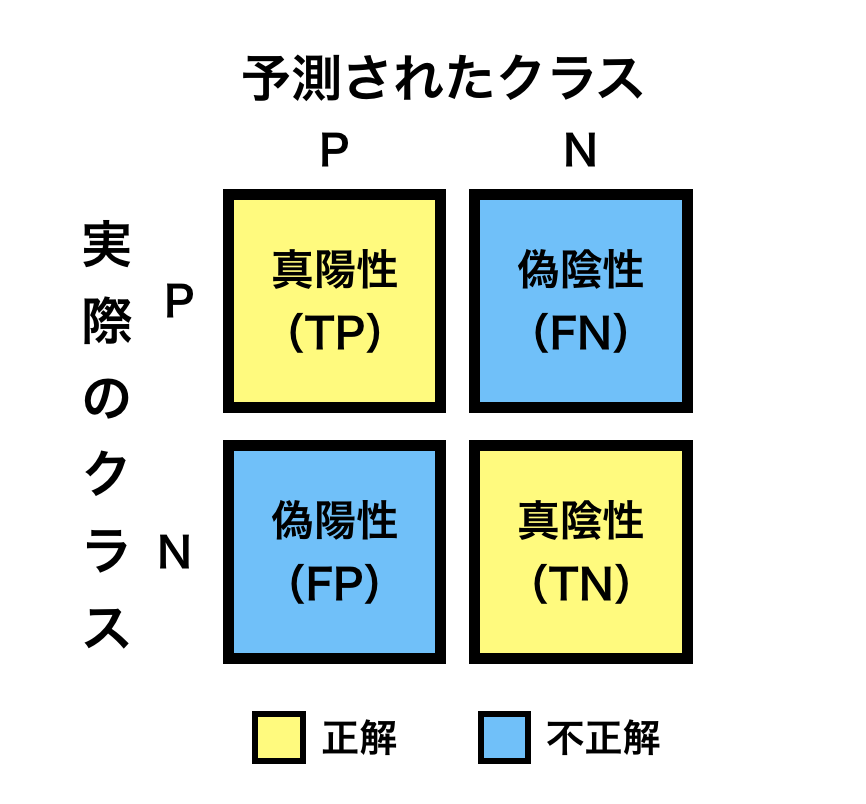  
正解率（ACC）は正しい予測の合計を予測の総数で割ったもので、予測の全体的な情報を表す。  
適合率（PRE）と再現率（REC）は、稀な疾患の有無を予測する臨床検査など、もともとのクラスが不均衡な場合に役立つ性能指標である。これらの値はトレードオフの関係にあり、実際にはこれらの調和平均をとったF値（F1）がよく使用される。  

$$
\begin{align}
&ACC = \frac{TP+TN}{FP+FN+TP+TN}\\
&PRE = \frac{TP}{FP+TP}\\
&REC = \frac{TP}{FN+TP}\\
&F1 = \frac{2\times PRE\times REC}{PRE + REC} = \frac{2\times TP}{2\times TP +FP+FN}
\end{align}
$$

### 【問題7】可視化  
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。以下にどう分割するかという **決定領域** を描く関数を用意しました。これを利用して可視化を行ってください。Xとyには訓練データまたは検証データを与えます。

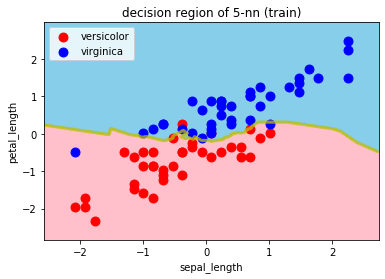

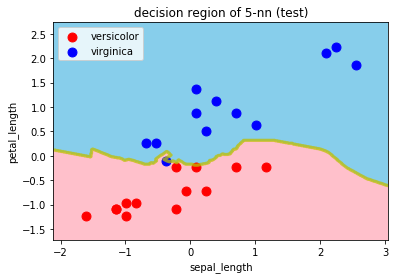

In [141]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

# 訓練データ
decision_region(X_train_std, y_train, knn_5, step=0.01, 
                title='decision region of 5-nn (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 検証データ
decision_region(X_test_std, y_test, knn_5, step=0.01, 
                title='decision region of 5-nn (test)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

### 【問題8】他の手法の学習  
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値で良かったかや、どういった決定領域になっていたかを述べてください。
- 最近傍法
- ロジスティック回帰
- SVM
- 決定木
- ランダムフォレスト
公式ドキュメントへのリンクは以下です。それぞれ調整すべき引数（ハイパーパラメータ）がありますが、この課題では扱いません。まずはデフォルトの値で実行してください。  

**《実際の問題では？》**  
ハイパーパラメータの調整は **パラメータチューニング** と呼ばれる工程で、その手法としてグリッドサーチなどが存在します。

Logistic Regression

Accuracy(LR): 0.96
Precision(LR): 0.93
Recall(LR): 1.00
F1 score(LR): 0.96

confusion matrix(LR) :
[[13  0]
 [ 1 11]]


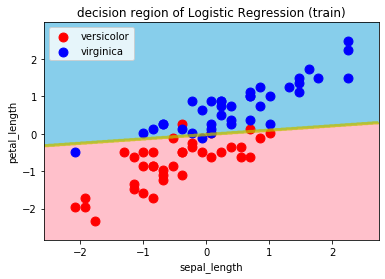

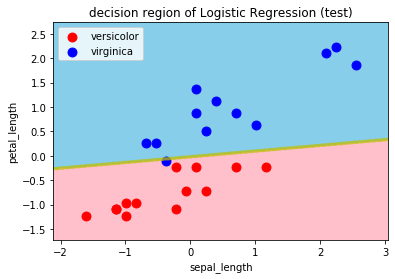

In [158]:
# ロジスティック回帰
print("Logistic Regression\n")
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

print("Accuracy(LR): {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision(LR): {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall(LR): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score(LR): {:.2f}\n".format(f1_score(y_test, y_pred)))

conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix(LR) :\n%s" % conmat)

decision_region(X_train_std, y_train, lr, step=0.01, 
                title='decision region of Logistic Regression (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

decision_region(X_test_std, y_test, lr, step=0.01, 
                title='decision region of Logistic Regression (test)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

Support Vector Machine

Accuracy(SVM): 1.00
Precision(SVM): 1.00
Recall(SVM): 1.00
F1 score(SVM): 1.00

confusion matrix(SVM) :
[[13  0]
 [ 0 12]]


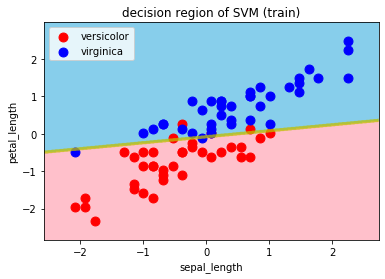

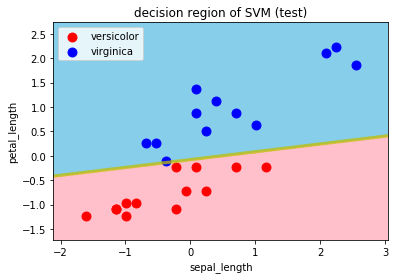

In [156]:
# SVM(カーネルなし)
print("Support Vector Machine\n")
from sklearn.svm import SVC
svm = SVC(kernel='linear')
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

print("Accuracy(SVM): {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision(SVM): {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall(SVM): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score(SVM): {:.2f}\n".format(f1_score(y_test, y_pred)))

conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix(SVM) :\n%s" % conmat)

decision_region(X_train_std, y_train, svm, step=0.01, 
                title='decision region of SVM (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

decision_region(X_test_std, y_test, svm, step=0.01, 
                title='decision region of SVM (test)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

Decision Tree

Accuracy(Tree): 0.92
Precision(Tree): 0.87
Recall(Tree): 1.00
F1 score(Tree): 0.93

confusion matrix(Tree) :
[[13  0]
 [ 2 10]]


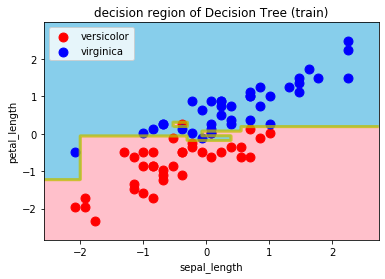

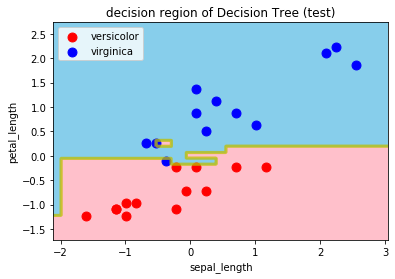

In [160]:
# 決定木
print("Decision Tree\n")
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)

print("Accuracy(Tree): {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision(Tree): {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall(Tree): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score(Tree): {:.2f}\n".format(f1_score(y_test, y_pred)))

conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix(Tree) :\n%s" % conmat)

decision_region(X_train_std, y_train, tree, step=0.01, 
                title='decision region of Decision Tree (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

decision_region(X_test_std, y_test, tree, step=0.01, 
                title='decision region of Decision Tree (test)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

Random Forest

Accuracy(Forest): 0.92
Precision(Forest): 0.87
Recall(Forest): 1.00
F1 score(Forest): 0.93

confusion matrix(Forest) :
[[13  0]
 [ 2 10]]


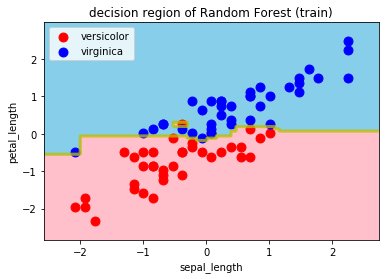

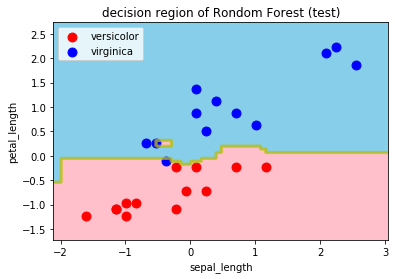

In [163]:
# ランダムフォレスト
print("Random Forest\n")
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train_std, y_train)
y_pred = forest.predict(X_test_std)

print("Accuracy(Forest): {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision(Forest): {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall(Forest): {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score(Forest): {:.2f}\n".format(f1_score(y_test, y_pred)))

conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix(Forest) :\n%s" % conmat)

decision_region(X_train_std, y_train, forest, step=0.01, 
                title='decision region of Random Forest (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

decision_region(X_test_std, y_test, forest, step=0.01, 
                title='decision region of Rondom Forest (test)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

### 【問題9】標準化の有無の比較  


< 5-nearest neighbor classifier >

1. Standardization(-)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00
confusion matrix :
[[13  0]
 [ 0 12]]


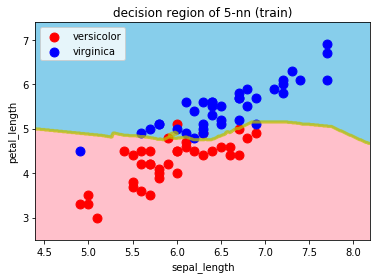



2. Standardization(+)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


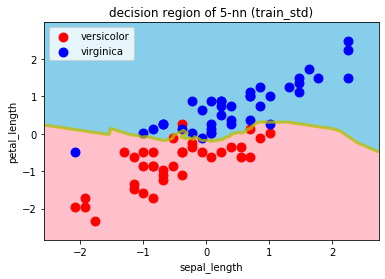

In [173]:
# 最近傍法(k=5)
# 標準化なし
print("< 5-nearest neighbor classifier >\n")
print("1. Standardization(-)\n")
knn_5.fit(X_train, y_train)
y_pred = knn_5.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train, y_train, knn_5, step=0.01, 
                title='decision region of 5-nn (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 標準化あり
print("\n\n2. Standardization(+)\n")
knn_5.fit(X_train_std, y_train)
y_pred = knn_5.predict(X_test_std)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train_std, y_train, knn_5, step=0.01, 
                title='decision region of 5-nn (train_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

#### ＜k近傍法＞  
irisデータセットでは、標準化の有無で指標値や決定境界に大きな変化は見られなかった。 今回の2つの特徴量はほぼ同じ範囲をとっていたため、標準化の意味合いは小さかったものと思われる。しかし最近傍法は距離を指標として予測を行うため、特徴量の範囲が大きく異なる際には、各特徴量の寄与を等しくするために標準化が必要になると思われる。

< Logistic Regression >

1. Standardization(-)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


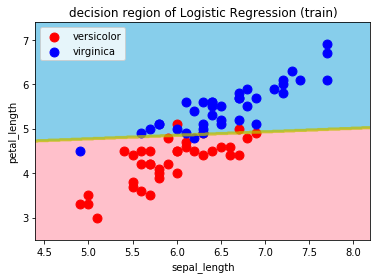



2. Standardization(+)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


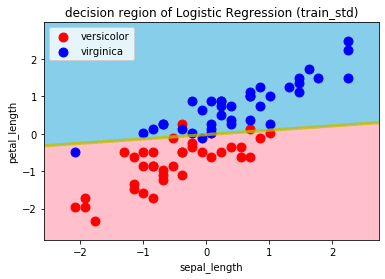

In [174]:
# ロジスティック回帰
# 標準化なし
print("< Logistic Regression >\n")
print("1. Standardization(-)\n")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train, y_train, lr, step=0.01, 
                title='decision region of Logistic Regression (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 標準化あり
print("\n\n2. Standardization(+)\n")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train_std, y_train, lr, step=0.01, 
                title='decision region of Logistic Regression (train_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

#### ＜ロジスティック回帰＞    
irisデータセットでは、標準化の有無で指標値や決定境界に大きな変化は見られなかった。  
しかしロジスティック回帰は勾配降下法で学習を行うため、特徴量の範囲が大きく異なる際には、学習を効率的に行うために標準化が必要になると思われる。

< Support Vector Machine >

1. Standardization(-)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


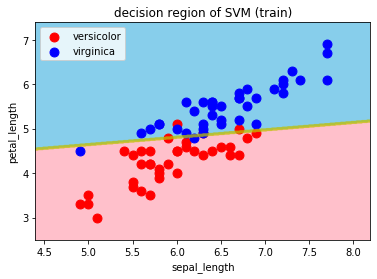



2. Standardization(+)

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1 score: 1.00
confusion matrix :
[[13  0]
 [ 0 12]]


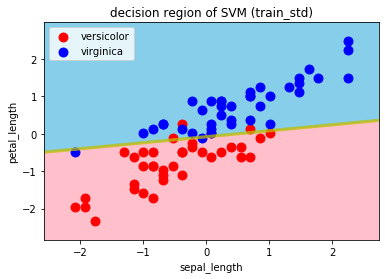

In [175]:
# SVM
# 標準化なし
print("< Support Vector Machine >\n")
print("1. Standardization(-)\n")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train, y_train, svm, step=0.01, 
                title='decision region of SVM (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 標準化あり
print("\n\n2. Standardization(+)\n")
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train_std, y_train, svm, step=0.01, 
                title='decision region of SVM (train_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

#### ＜SVM＞    
irisデータセットでは、標準化の有無で指標値や決定境界に大きな変化は見られなかった。  
しかし、SVMはサポートベクトルからのマージンを計算して学習を行うため、特徴量の範囲が大きく異なる際には、各特徴量の寄与を等しくするために標準化が必要になると思われる。

< Decision Tree >

1. Standardization(-)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


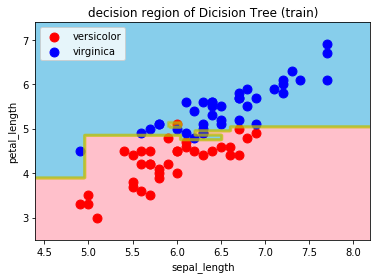



2. Standardization(+)

Accuracy: 0.92
Precision: 0.87
Recall: 1.00
F1 score: 0.93
confusion matrix :
[[13  0]
 [ 2 10]]


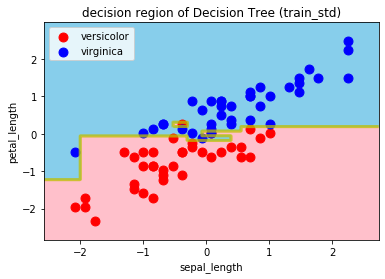

In [177]:
# 決定木
# 標準化なし
print("< Decision Tree >\n")
print("1. Standardization(-)\n")
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train, y_train, tree, step=0.01, 
                title='decision region of Dicision Tree (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 標準化あり
print("\n\n2. Standardization(+)\n")
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train_std, y_train, tree, step=0.01, 
                title='decision region of Decision Tree (train_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

#### ＜決定木＞    
irisデータセットでは、標準化の有無で指標値や決定境界に大きな変化は見られなかった。  
決定木は数値の分割条件を値の大小関係でとらえるため、スケーリングは分割に影響を与えない。よって可視化する上で問題とならない限り、標準化は必須でない。

< Random Forest >

1. Standardization(-)

Accuracy: 0.96
Precision: 0.93
Recall: 1.00
F1 score: 0.96
confusion matrix :
[[13  0]
 [ 1 11]]


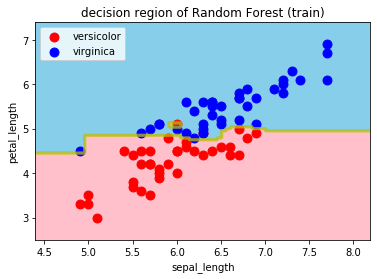



2. Standardization(+)

Accuracy: 0.92
Precision: 0.87
Recall: 1.00
F1 score: 0.93
confusion matrix :
[[13  0]
 [ 2 10]]


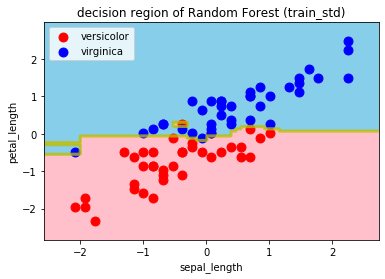

In [179]:
# ランダムフォレスト
# 標準化なし
print("< Random Forest >\n")
print("1. Standardization(-)\n")
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train, y_train, forest, step=0.01, 
                title='decision region of Random Forest (train)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

# 標準化あり
print("\n\n2. Standardization(+)\n")
forest.fit(X_train_std, y_train)
y_pred = forest.predict(X_test_std)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(f1_score(y_test, y_pred)))
conmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print("confusion matrix :\n%s" % conmat)

decision_region(X_train_std, y_train, forest, step=0.01, 
                title='decision region of Random Forest (train_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['versicolor', 'virginica'])

#### ＜ランダムフォレスト＞    
irisデータセットでは、標準化の有無で指標値や決定境界に大きな変化は見られなかった。  
ランダムフォレストは決定木のアンサンブル学習であるため、決定木と同様に標準化は必須でない。

### 【問題10】全ての目的変数を使用して精度が高い手法  
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。  

**《多値になることでの変更点》**  
指標値Precision（適合率）、Recall（再現率）、F値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使います。

In [182]:
# 全ての品種のデータを作成
X = iris.data[:, [0, 2]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y)

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# 決定領域描画の関数を編集
def decision_region_3(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['setosa', 'versicolor', 'virginica']):
    # setting
    scatter_color = ['green', 'red', 'blue']
    contourf_color = ['lightgreen', 'pink', 'skyblue']
    n_class = 3
    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))        
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

< 5-nearest neighbor classifier >

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.93      1.00      0.96        13
           2       1.00      0.92      0.96        12

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



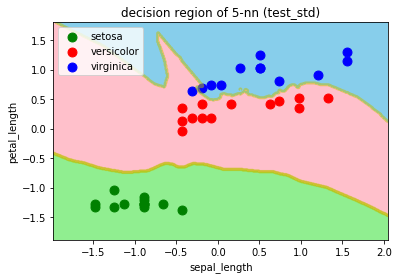

In [193]:
# 条件をそろえるため、全ての手法で標準化する
# 5NN
print("< 5-nearest neighbor classifier >\n")
knn_5.fit(X_train_std, y_train)
y_pred = knn_5.predict(X_test_std)

# 指標値一覧
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# 決定境界の描画
decision_region_3(X_test_std, y_test, knn_5, step=0.01, 
                title='decision region of 5-nn (test_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['setosa', 'versicolor', 'virginica'])

< Logistic Regression >

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.86      0.92      0.89        13
           2       0.91      0.83      0.87        12

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



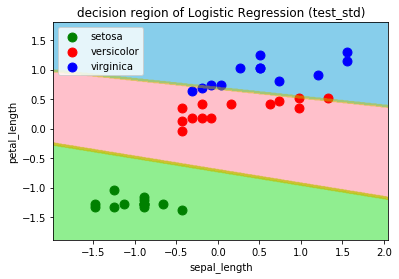

In [192]:
# LR
print("< Logistic Regression >\n")
lr.fit(X_train_std, y_train)
y_pred = lr.predict(X_test_std)

# 指標値一覧
print(classification_report(y_test, y_pred))

# 決定境界の描画
decision_region_3(X_test_std, y_test, lr, step=0.01, 
                title='decision region of Logistic Regression (test_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['setosa', 'versicolor', 'virginica'])

< Support Vector Machine >

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



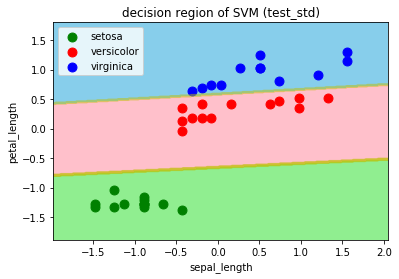

In [191]:
# SVM
print("< Support Vector Machine >\n")
svm.fit(X_train_std, y_train)
y_pred = svm.predict(X_test_std)

# 指標値一覧
print(classification_report(y_test, y_pred))

# 決定境界の描画
decision_region_3(X_test_std, y_test, svm, step=0.01, 
                title='decision region of SVM (test_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['setosa', 'versicolor', 'virginica'])

< Decision Tree >

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.81      1.00      0.90        13
           2       1.00      0.75      0.86        12

    accuracy                           0.92        38
   macro avg       0.94      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38



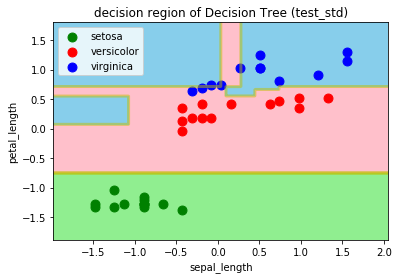

In [194]:
# 決定木
print("< Decision Tree >\n")
tree.fit(X_train_std, y_train)
y_pred = tree.predict(X_test_std)

# 指標値一覧
print(classification_report(y_test, y_pred))

# 決定境界の描画
decision_region_3(X_test_std, y_test, tree, step=0.01, 
                title='decision region of Decision Tree (test_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['setosa', 'versicolor', 'virginica'])

< Random Forest >

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.87      1.00      0.93        13
           2       1.00      0.83      0.91        12

    accuracy                           0.95        38
   macro avg       0.96      0.94      0.95        38
weighted avg       0.95      0.95      0.95        38



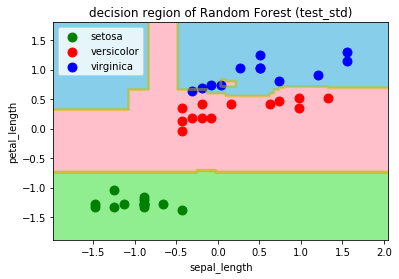

In [195]:
# ランダムフォレスト
print("< Random Forest >\n")
forest.fit(X_train_std, y_train)
y_pred = forest.predict(X_test_std)

# 指標値一覧
print(classification_report(y_test, y_pred))

# 決定境界の描画
decision_region_3(X_test_std, y_test, forest, step=0.01, 
                title='decision region of Random Forest (test_std)', 
                xlabel='sepal_length', ylabel='petal_length', 
                target_names=['setosa', 'versicolor', 'virginica'])

#### ＜考察＞  
irisデータセットは各品種のデータ数が等しいためクラスの不均衡が存在せず、正解率のみで評価をしても問題ないかと思われる。不均衡が存在する場合は、マクロ平均で計算されたF値を評価指標として使うのが適切と考えるが、クラスの重要度に応じてマイクロ平均と使い分ける。  
正解率と決定領域の形状の自然さから考えて、今回の手法の中ではSVM（カーネルなし）が最も精度が高いのではないかと思われる。